Hunter Bennett | Glass Lab | Brain Aging Project | 12 Feb 2021  

This is a re-vamp of the differential peak calling pipeline for comparisons within strains in a given condition (healthy, CCl4, NASH). This pipeline takes in ATAC-seq peaks and compares paiwised between groups. The main outputs of this file are:
1. A homer differential peak file containing each pairwise comparison.
2. Scatterplots of each pairwise comparison with significant peaks highlighted.
3. Heatmaps of differential peaks across all comparisons to highlight patterns.
4. Peak files for GREAT analysis of functional annotations associated with genomic regions.

In [7]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 200
sns.set(font_scale=1)
sns.set_context('talk')
sns.set_style('white')

# import custom functions
import sys
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df
from plotting_scripts import label_point, pca_rpkm_mat, get_diff_volcano
from homer_preprocessing import read_annotated_peaks, import_homer_diffpeak, pull_comparisons_get_diff

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
dataDirectory = '/data/mm10/Brain_MPSIIIA/ATAC/Microglia/'
workingDirectory = '/home/h1bennet/brain_aging/results/00_Microglia_ATAC/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)


### Read in raw gene expression files

In [12]:
df, mat = read_annotated_peaks('./merged_peaks/ann_raw_idr_peaks_merged.txt')

In [13]:
mat.columns

Index(['/gpfs/data01/glasslab/data/mm10/Brain_MPSIIIA/ATAC/Microglia/00_mouse_Bl6_WT_F_4months_Microglia_ATAC_1_JOS_AGGCAGAA',
       '/gpfs/data01/glasslab/data/mm10/Brain_MPSIIIA/ATAC/Microglia/00_mouse_Bl6_WT_F_4months_Microglia_ATAC_2_JOS_GGACTCCT',
       '/gpfs/data01/glasslab/data/mm10/Brain_MPSIIIA/ATAC/Microglia/00_mouse_Bl6_WT_M_14wks_Microglia_ATAC_1_JOS_GAGGGGTT',
       '/gpfs/data01/glasslab/data/mm10/Brain_MPSIIIA/ATAC/Microglia/00_mouse_Sall1WTEnhancer_M_Microglia_ATAC_rep3_BF_l20200128_AAGGAACG',
       '/gpfs/data01/glasslab/data/mm10/Brain_MPSIIIA/ATAC/Microglia/00_mouse_Sall1WTEnhancer_M_Microglia_ATAC_rep4_BF_l20200128_CCAACTCG',
       '/gpfs/data01/glasslab/data/mm10/Brain_MPSIIIA/ATAC/Microglia/01_mouse_Bl6_WT_F_25months_Microglia_ATAC_1_JOS_CCGTTTGT',
       '/gpfs/data01/glasslab/data/mm10/Brain_MPSIIIA/ATAC/Microglia/01_mouse_Bl6_WT_M_25months_Microglia_ATAC_1_AL_CGATATCA',
       '/gpfs/data01/glasslab/data/mm10/Brain_MPSIIIA/ATAC/Microglia/01_mouse_Bl6_WT_M

Select best replicates if filtering in Annotation step supports sample exclusion

In [14]:
best_reps = ['/gpfs/data01/glasslab/data/mm10/Brain_MPSIIIA/ATAC/Microglia/00_mouse_Bl6_WT_F_4months_Microglia_ATAC_1_JOS_AGGCAGAA',
       '/gpfs/data01/glasslab/data/mm10/Brain_MPSIIIA/ATAC/Microglia/00_mouse_Bl6_WT_F_4months_Microglia_ATAC_2_JOS_GGACTCCT',
       '/gpfs/data01/glasslab/data/mm10/Brain_MPSIIIA/ATAC/Microglia/00_mouse_Sall1WTEnhancer_M_Microglia_ATAC_rep3_BF_l20200128_AAGGAACG',
       '/gpfs/data01/glasslab/data/mm10/Brain_MPSIIIA/ATAC/Microglia/00_mouse_Sall1WTEnhancer_M_Microglia_ATAC_rep4_BF_l20200128_CCAACTCG',
       '/gpfs/data01/glasslab/data/mm10/Brain_MPSIIIA/ATAC/Microglia/01_mouse_Bl6_WT_F_25months_Microglia_ATAC_1_JOS_CCGTTTGT',
       '/gpfs/data01/glasslab/data/mm10/Brain_MPSIIIA/ATAC/Microglia/01_mouse_Bl6_WT_M_25months_Microglia_ATAC_1_AL_CGATATCA',
       '/gpfs/data01/glasslab/data/mm10/Brain_MPSIIIA/ATAC/Microglia/01_mouse_Bl6_WT_M_25months_Microglia_ATAC_2_AL_GAAGTCCG',
       '/gpfs/data01/glasslab/data/mm10/Brain_MPSIIIA/ATAC/Microglia/01_mouse_Bl6_WT_M_25months_Microglia_ATAC_3_AL_CATAACCG']

In [15]:
# import annotation file
df, mat = read_annotated_peaks('./merged_peaks/ann_raw_idr_peaks_merged.txt')

# pull out selected samples
tst = np.append(np.asarray([True]*18, 'bool'), mat.columns.str.contains('|'.join(best_reps)))
df= df.loc[:, tst]

df.to_csv('./merged_peaks/ann_raw_idr_peaks_merged_samples_filtered.txt', sep='\t')

In [16]:
df.columns

Index(['Chr', 'Start', 'End', 'Strand', 'Peak Score',
       'Focus Ratio/Region Size', 'Annotation', 'Detailed Annotation',
       'Distance to TSS', 'Nearest PromoterID', 'Entrez ID', 'Nearest Unigene',
       'Nearest Refseq', 'Nearest Ensembl', 'Gene Name', 'Gene Alias',
       'Gene Description', 'Gene Type',
       '/gpfs/data01/glasslab/data/mm10/Brain_MPSIIIA/ATAC/Microglia/00_mouse_Bl6_WT_F_4months_Microglia_ATAC_1_JOS_AGGCAGAA',
       '/gpfs/data01/glasslab/data/mm10/Brain_MPSIIIA/ATAC/Microglia/00_mouse_Bl6_WT_F_4months_Microglia_ATAC_2_JOS_GGACTCCT',
       '/gpfs/data01/glasslab/data/mm10/Brain_MPSIIIA/ATAC/Microglia/00_mouse_Sall1WTEnhancer_M_Microglia_ATAC_rep3_BF_l20200128_AAGGAACG',
       '/gpfs/data01/glasslab/data/mm10/Brain_MPSIIIA/ATAC/Microglia/00_mouse_Sall1WTEnhancer_M_Microglia_ATAC_rep4_BF_l20200128_CCAACTCG',
       '/gpfs/data01/glasslab/data/mm10/Brain_MPSIIIA/ATAC/Microglia/01_mouse_Bl6_WT_F_25months_Microglia_ATAC_1_JOS_CCGTTTGT',
       '/gpfs/data01/g

In [5]:
# %%bash
# source activate deseq_36
# getDiffExpression.pl ./merged_peaks/ann_raw_idr_peaks_merged_samples_filtered.txt \
# 00_microglia_4months 00_microglia_4months 00_microglia_4months 00_microglia_4months \
# 01_microglia_25months 01_microglia_25months 01_microglia_25months 01_microglia_25months \
# -AvsA -peaks > ./merged_peaks/diff_output.txt


### Import differential peaks

In [22]:
diff_peak, peaks, peak_mat, peak_mat_quant = import_homer_diffpeak(
    './merged_peaks/diff_output.txt',
    './merged_peaks/ann_norm_idr_peaks_merged.txt')

annotatePeaks all peaks (119988, 28)
getDiffExpression selected transcripts (90070, 29)
annotatePeaks selected peaks (90070, 28)


In [23]:
# pull out selected samples
cols = np.append(np.asarray([True]*18, 'bool'), peak_mat.columns.str.contains('|'.join(best_reps)))
peaks = peaks.loc[:, tst]
peak_mat = peak_mat.loc[:, peak_mat.columns.str.contains('|'.join(best_reps))]

In [24]:
comp_dict = pull_comparisons_get_diff(diff_peak, seq_type='Peak')

In [25]:
comp_dict.keys()

dict_keys(['00_microglia_4months vs. 01_microglia_25months'])

In [38]:
comps = ['00_microglia_4months vs. 01_microglia_25months']

groups = [[[0,1,2,3],
         [4,5,6,7]]]

cols = []
for i in groups:
    subcols = []
    for j in i:
        subcols.extend([k for k in j])
    cols.append(subcols)

colors = [['#6baed6', '#3182bd']]

00_microglia_4months vs. 01_microglia_25months
N genes downregulated 47
N genes upregulated 178



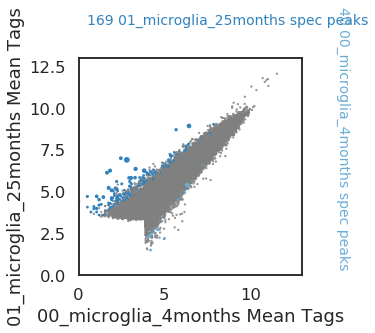

In [40]:
for key, col, group, color in zip(comps, cols, groups, colors):
#     print(key)
#     print('mean calculated using tag dirs:')
#     for colid in peak_mat.iloc[:, col].columns.tolist():
#         print(colid)
#     print('')
    de = comp_dict[key]
    de['logtpm'] = np.log2(peak_mat.iloc[:, col].mean(1)+1)
    de['log10p'] = -np.log10(de.adj_pval + 10**(-50))
    de['g0_mean'] = np.log2(peak_mat.iloc[:, group[0]].mean(1)+1)
    de['g1_mean'] = np.log2(peak_mat.iloc[:, group[1]].mean(1)+1)
    dot_colors = []
    dot_sizes = []
    for index, row in de.iterrows():
        if (row.adj_pval <= 0.05) & (-row.log2fc < 0):
            dot_colors.append(color[1])
            dot_sizes.append(row.log10p)
        elif (row.adj_pval <= 0.05) & (-row.log2fc > 0):
            dot_colors.append(color[0])
            dot_sizes.append(row.log10p)
        else:
            dot_colors.append('grey')
            dot_sizes.append(0.5)
    print(key)
    print('N genes downregulated', np.sum((de.adj_pval <= 0.05) & (de.log2fc < 0)))
    print('N genes upregulated', np.sum((de.adj_pval <= 0.05) & (de.log2fc > 0)))
    print('')
    fig, axs = plt.subplots(1, 2, figsize=(10,6))
    plt.subplots_adjust(wspace=0.5)

    axs[0].set_xlim(left=-np.ceil(np.max(np.abs(de.log2fc))),
                right=np.ceil(np.max(np.abs(de.log2fc))))
    axs[0].scatter(
        x=de.log2fc,
        y=de.logtpm,
        s=dot_sizes, #de.log10p+0.05,
        c=dot_colors)

    axs[0].set_ylabel('Mean Log2(TPM)')
    axs[0].set_xlabel('Log2FC')

    # plot group by group scatter:
    axs[1].scatter(
        x=de.g0_mean,
        y=de.g1_mean,
        s=dot_sizes, #de.log10p+0.05,
        c=dot_colors)
    
    axs[1].set_xlabel(key.split(' vs. ')[0] + ' Mean Tags')
    axs[1].set_ylabel(key.split(' vs. ')[1] + ' Mean Tags')
    
    #set max and min
    countmax = np.max([np.max(de.g0_mean), np.max(de.g1_mean)])
    axs[1].set_xlim([0,np.ceil(countmax)])
    axs[1].set_ylim([0,np.ceil(countmax)])
                      
    plt.savefig('./figures/'+key+'_MAPlot_scatter.png', bbox_inches='tight')
    plt.close()
    
    fig, ax = plt.subplots(figsize=(4,4))
    
        # plot group by group scatter:
    ax.scatter(
        x=de.g0_mean,
        y=de.g1_mean,
        s=dot_sizes, #de.log10p+0.05,
        c=dot_colors)
    
    ax.set_xlabel(key.split(' vs. ')[0] + ' Mean Tags')
    ax.set_ylabel(key.split(' vs. ')[1] + ' Mean Tags')
    
    #set max and min
    countmax = np.max([np.max(de.g0_mean), np.max(de.g1_mean)])
    ax.set_xlim([0,np.ceil(countmax)])
    ax.set_ylim([0,np.ceil(countmax)])
    
    ax.text(0.5,15,
        s='%d %s spec peaks' % (np.sum((de.adj_pval <= 0.05) & (de.log2fc > 1)), key.split(' vs. ')[1]),
        fontsize=14,
        c=color[1])
    ax.text(15,0.5,
        s='%d %s spec peaks' % (np.sum((de.adj_pval <= 0.05) & (de.log2fc < -1)), key.split(' vs. ')[0]),
        fontsize=14,
        c=color[0],
        rotation=-90)
    
    plt.savefig('./figures/'+key+'_scatter.png', bbox_inches='tight')
    # plt.close()

# Cluster differential enhancers:
____
### All enhancers

96


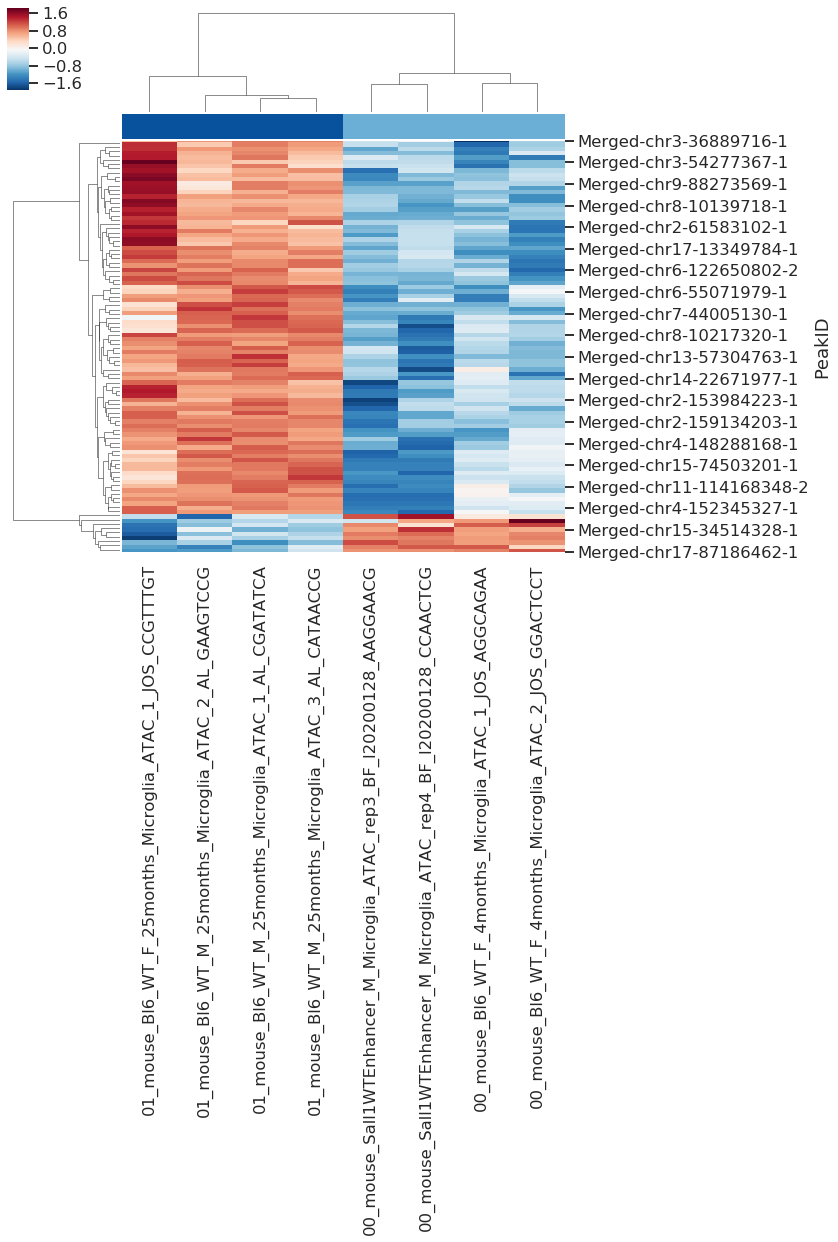

In [41]:
pval = 0.05
fc = 2

# grab differential enhancers for each comparison
sig_peaks_id = []
for comp in comps:
    de = comp_dict[comp]
    sig_peaks_id.extend(de.loc[((de.adj_pval <= pval) & (np.abs(de.log2fc) >= fc)), :].index.tolist())

sig_peaks_id = np.unique(sig_peaks_id)
print(len(sig_peaks_id))
sig_peaks = peak_mat.reindex(sig_peaks_id)
sig_peaks.columns = sig_peaks.columns.str.split('/').str[-1].str.split(' Tag Count').str[0]

sns.clustermap(np.log2(sig_peaks+1),
               z_score=0,
               cmap='RdBu_r',
               col_colors=['#6baed6', '#6baed6','#6baed6', '#6baed6',
                           '#08519c', '#08519c', '#08519c', '#08519c'])
plt.savefig('./figures/diff_peaks_clustermap.png', bbox_inches='tight')

### distal enhancers only

164


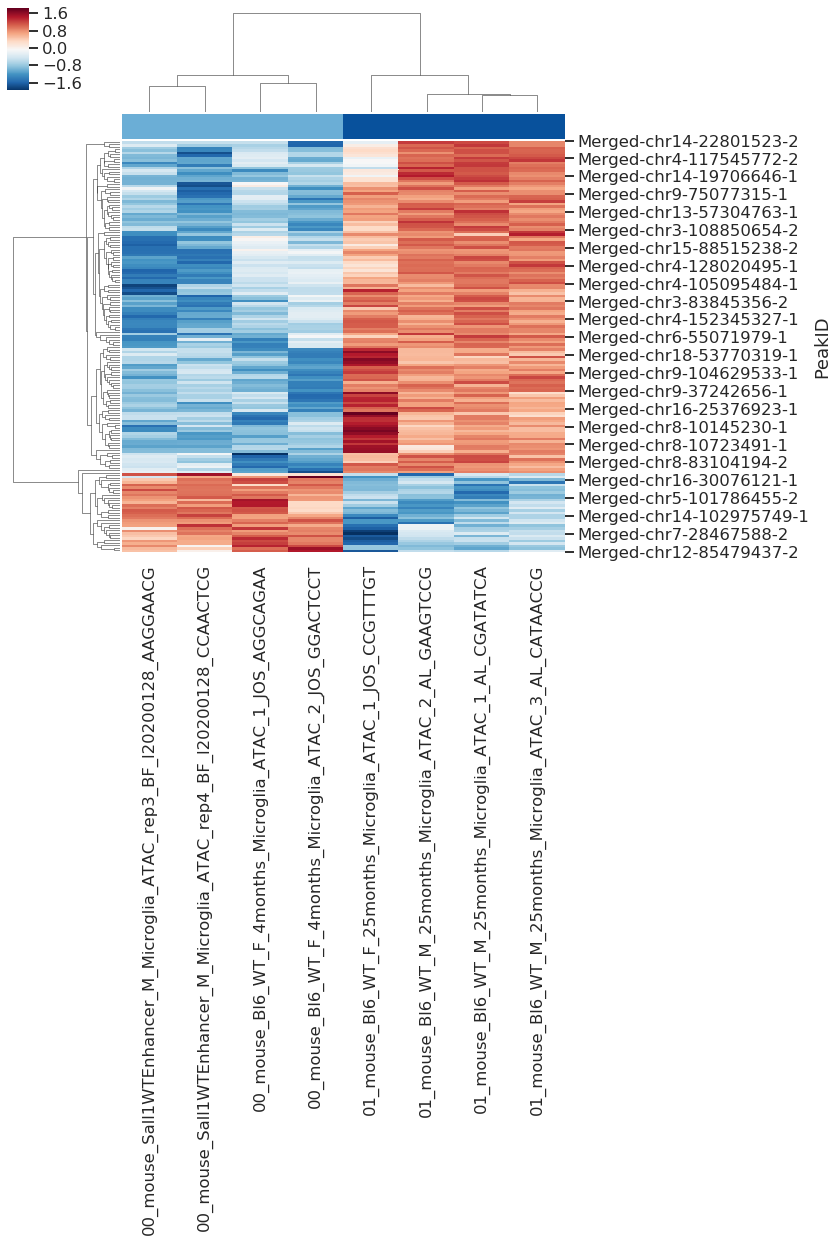

In [44]:
pval = 0.05
fc = 1

# grab differential enhancers for each comparison
sig_peaks_id = []
for comp in comps:
    de = comp_dict[comp]
    sig_peaks_bool = (((de.adj_pval <= pval) & (np.abs(de.log2fc) >= fc)) & (np.abs(de.TSS_dist) >= 3000))
    sig_peaks_id.extend(de.loc[sig_peaks_bool, :].index.tolist())

sig_peaks_id = np.unique(sig_peaks_id)
print(len(sig_peaks_id))
sig_peaks = peak_mat.reindex(sig_peaks_id)
sig_peaks.columns = sig_peaks.columns.str.split('/').str[-1].str.split(' Tag Count').str[0]

sns.clustermap(np.log2(sig_peaks+1),
               z_score=0,
               cmap='RdBu_r',
               col_colors=['#6baed6', '#6baed6','#6baed6', '#6baed6',
                           '#08519c', '#08519c', '#08519c', '#08519c'])
plt.savefig('./figures/diff_peaks_distal_clustermap.png', bbox_inches='tight')

# Save differential peaks for analysis in GREAT

In [45]:
if not os.path.isdir('./great_analysis/'):
    os.mkdir('./great_analysis/')
    
if not os.path.isdir('./great_analysis/peak_files/'):
    os.mkdir('./great_analysis/peak_files/')
    
if not os.path.isdir('./great_analysis/bed_files/'):
    os.mkdir('./great_analysis/bed_files/')

In [47]:
# initialize dict and list of cell types
peak_lists = {}
bg_lists = {}
cells = ['00_microglia_4months',
         '01_microglia_25months']

# set pvalue and fc thresholds
fc = np.log2(2)
pval = 0.05

for cell in cells:
    print('Analyzing', cell, '...\n')
    
    # set count
    count = 0
    
    for key in comp_dict.keys():
        
        # select get diff data frame.
        df = comp_dict[key]
        
        # check on counter
        print(count)


        # initialize lists if count == 0
        if count == 0:
            # fold change direction depends on the location of the cell in the comparison.
            # if cell is in first position it is reference - so negative log2fc is higher in first position
            if cell in key.split(' vs. ')[0]:
                u = set(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] < -fc)])
                i = set(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] < -fc)])
                count = count + 1
            # if cell is in second position it is comparison - so positive log2fc is higher in second position
            elif cell in key.split(' vs. ')[1]:
                u = set(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] > fc)])
                i = set(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] > fc)])
                count = count + 1

        else:
            # fold change direction depends on the location of the cell in the comparison.
            # if cell is in first position it is reference - so negative log2fc is higher in first position
            if cell in key.split(' vs. ')[0]:
                u = u.union(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] < -fc)])
                i = i.intersection(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] < -fc)])
                count = count + 1
            # if cell is in second position it is comparison - so positive log2fc is higher in second position
            elif cell in key.split(' vs. ')[1]:
                u = u.union(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] > fc)])
                i = i.intersection(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] > fc)])
                count = count + 1

        
        # summarize iteration
        print('For comp:', key)
        print('Union set at:', len(u), 'peaks')
        print('Intersection set at:', len(i), 'peaks\n')
     
    
        # store lists
        peak_lists[cell+'_union'] = u
        peak_lists[cell+'_intersection'] = i

Analyzing 00_microglia_4months ...

0
For comp: 00_microglia_4months vs. 01_microglia_25months
Union set at: 40 peaks
Intersection set at: 40 peaks

Analyzing 01_microglia_25months ...

0
For comp: 00_microglia_4months vs. 01_microglia_25months
Union set at: 169 peaks
Intersection set at: 169 peaks



if np.NaN get introduced into the matrix then it converts 'int' type columns to 'float' type columns, this is not ideal and interferes with downstream peak analysis so we create a dict to change the start and end columns back to integers just in case

In [48]:
convert_dict = {'Start': int,
                'End': int}

for key in peak_lists.keys():
    # save cell specific promoters
    tmp = diff_peak.reindex(peak_lists[key]).dropna(how='all').iloc[:, :4]
    tmp = tmp.astype(convert_dict)
    tmp.to_csv('./great_analysis/peak_files/'+key+'_poised_peaks.txt',
               sep='\t')

Save full set of peaks for background

In [49]:
diff_peak.iloc[:, :4].to_csv(
    './great_analysis/peak_files/all_peaks.txt',
    sep='\t')

Convert peaks to bed file

In [50]:
%%bash
# delete the existing script file
rm ./peak_to_bed_great.sh
# create a script file
touch ./peak_to_bed_great.sh

In [51]:
%%bash
for peakfile in ./great_analysis/peak_files/*txt;
do bedfile=${i/act/bg};
out=${peakfile/.txt/.bed};
out=${out/peak_files/bed_files}
echo "pos2bed.pl -o $out $peakfile" >> ./peak_to_bed_great.sh
done

# Create bed files for visualization in browser

In [29]:
if not os.path.isdir('./bed_files/'):
    os.mkdir('./bed_files/')

In [30]:
!cp ./great_analysis/bed_files/* ./bed_files/

In [52]:
!ls ./bed_files/

00_microglia_4months_union_poised_peaks.bed   all_peaks.bed
01_microglia_25months_union_poised_peaks.bed


In [61]:
with open('./label_bed.sh', 'w') as f:
    for i in glob.glob('./bed_files/*poised_peaks.bed'):
       
        cell = i.split('/')[-1].split('_')[1]
        age = i.split('/')[-1].split('_')[2]
        # group = "Microglia"
        chip = 'ATAC'

        # set track names for upload to ucsc genome browser
        lab = "'track name=\"%s_%s_%s\" description=\"%s %s %s DESeq2\"'" % (cell, chip, age, cell, chip, age)
        lab_dist = "'track name=\"%s_%s_%s_distal\" description=\"%s %s %s DESeq2\"'" % (cell, chip, age, cell, chip, age)

        # set labels - can't think of a more clever way to do this so we will just
        # use the simple if / else statement to switch labels depending on our 
        # peak set being distal or all
        
        if 'distal' in i:
            l = lab_dist
        else:
            l = lab
        
        label_track = ['echo', l, '|', 'cat', '-',
                       i,
                       '> temp && mv temp',
                       i, '\n']
    
        f.write(' '.join(label_track))
        
    f.close()

label all peaks post-hoc

In [33]:
%%bash

echo 'track name="microglia_ATAC_4months_25months" description="microglia 4month and 25 month ATAC-seq peaks"' \
| cat - ./bed_files/all_peaks.bed \
> temp && mv temp ./bed_files/all_peaks.bed

# Check differential peak quality in browser

In [34]:
# make location column for peak dict (for examining on browser)
diff_peak['location'] = diff_peak.Chr + ':' + diff_peak.Start.map(str) + '-' + diff_peak.End.map(str)

In [57]:
diff_peak.sort_values('00_microglia_4months vs. 01_microglia_25months adj. p-value', ascending=True).head(20)

,Chr,Start,End,Strand,Peak Score,Focus Ratio/Region Size,Annotation,Detailed Annotation,Distance to TSS,Nearest PromoterID,...,/gpfs/data01/glasslab/data/mm10/Brain_MPSIIIA/ATAC/Microglia/00_mouse_Bl6_WT_F_4months_Microglia_ATAC_2_JOS_GGACTCCT,/gpfs/data01/glasslab/data/mm10/Brain_MPSIIIA/ATAC/Microglia/00_mouse_Sall1WTEnhancer_M_Microglia_ATAC_rep3_BF_l20200128_AAGGAACG,/gpfs/data01/glasslab/data/mm10/Brain_MPSIIIA/ATAC/Microglia/00_mouse_Sall1WTEnhancer_M_Microglia_ATAC_rep4_BF_l20200128_CCAACTCG,/gpfs/data01/glasslab/data/mm10/Brain_MPSIIIA/ATAC/Microglia/01_mouse_Bl6_WT_F_25months_Microglia_ATAC_1_JOS_CCGTTTGT,/gpfs/data01/glasslab/data/mm10/Brain_MPSIIIA/ATAC/Microglia/01_mouse_Bl6_WT_M_25months_Microglia_ATAC_1_AL_CGATATCA,/gpfs/data01/glasslab/data/mm10/Brain_MPSIIIA/ATAC/Microglia/01_mouse_Bl6_WT_M_25months_Microglia_ATAC_2_AL_GAAGTCCG,/gpfs/data01/glasslab/data/mm10/Brain_MPSIIIA/ATAC/Microglia/01_mouse_Bl6_WT_M_25months_Microglia_ATAC_3_AL_CATAACCG,00_microglia_4months vs. 01_microglia_25months Log2 Fold Change,00_microglia_4months vs. 01_microglia_25months p-value,00_microglia_4months vs. 01_microglia_25months adj. p-value
PeakID,,,,,,,,,,,,,,,,,,,,,
Merged-chr2-159134203-1,chr2,159134103,159134303,+,1000.000000,./atac_peak_files/microglia_25months.idr,Intergenic,Intergenic,339396.0,NM_001291144,...,4.730901,4.259749,4.634343,6.703159,6.452593,6.469038,6.386478,4.159060,1.207618e-23,1.087399e-18
Merged-chr10-76962015-2,chr10,76961915,76962115,+,1000.000000,./atac_peak_files/microglia_25months.idr|./ata...,promoter-TSS (NM_021568),promoter-TSS (NM_021568),-68.0,NM_021568,...,7.345568,7.470743,7.424000,9.175830,8.617254,8.698464,8.503077,2.415021,2.919042e-15,1.314226e-10
Merged-chr7-129401521-2,chr7,129401401,129401601,+,869.833374,./atac_peak_files/microglia_25months.idr|./ata...,Intergenic,Intergenic,144407.0,NM_001080963,...,4.648804,4.923486,4.995073,6.142029,5.948755,6.026740,6.080351,2.394123,1.636972e-14,4.913371e-10
Merged-chr2-92380058-1,chr2,92379958,92380158,+,1000.000000,./atac_peak_files/microglia_25months.idr,"intron (NM_145122, intron 9 of 10)","intron (NM_145122, intron 9 of 10)",-2860.0,NM_183112,...,4.563819,4.815272,4.190447,6.322532,6.000367,5.985289,5.961722,3.050671,1.962155e-12,4.417056e-08
Merged-chr1-38777648-2,chr1,38777564,38777764,+,776.714294,./atac_peak_files/microglia_25months.idr|./ata...,Intergenic,Intergenic,43551.0,NM_001029878,...,4.300054,4.236609,3.959185,5.582856,5.606630,5.634379,5.280056,2.770368,3.828643e-12,6.895003e-08
Merged-chr15-74503201-1,chr15,74503101,74503301,+,1000.000000,./atac_peak_files/microglia_25months.idr,Intergenic,Intergenic,-12995.0,NM_174991,...,4.112480,3.547780,3.552434,5.382679,5.798619,5.744505,6.031339,4.670971,8.746940e-12,1.312697e-07
Merged-chr17-13349784-1,chr17,13349684,13349884,+,887.666687,./atac_peak_files/microglia_25months.idr,Intergenic,Intergenic,-4788.0,NM_001167578,...,3.300433,3.255737,3.507984,5.183572,4.712572,4.804418,4.565317,3.827679,3.503683e-11,4.506988e-07
Merged-chr15-74519709-1,chr15,74519609,74519809,+,967.333313,./atac_peak_files/microglia_25months.idr,"intron (NM_001359759, intron 1 of 30)",CpG,3513.0,NM_001359759,...,3.448664,3.226549,3.136656,4.891701,4.609702,4.641673,4.686124,3.422379,5.445267e-11,6.128988e-07
Merged-chr4-128061480-1,chr4,128061380,128061580,+,956.000000,./atac_peak_files/microglia_25months.idr,"intron (NM_001281955, intron 2 of 70)","intron (NM_001281955, intron 2 of 70)",73436.0,NM_001281955,...,3.791258,3.406050,3.410780,4.841378,5.793663,5.652003,5.824938,4.799658,1.419375e-10,1.420085e-06
